# **Predicting tweet sentiment**

Dataset from https://www.kaggle.com/datasets/bhavikjikadara/tweets-dataset

**Context**

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = negative, 4 = positive) and can be used to detect sentiment.

**Content**

It contains the following 6 fields:

* target: the polarity of the tweet (0 = negative and 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted.
* text: the text of the tweet.

## **1. Exploratory Data Analysis** 

In [5]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%pip install contractions, wordcloud, tensorflow

# text processing libraries
import re
import contractions

from collections import Counter
# import string
import nltk
# import warnings
# %matplotlib inline
# warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'contractions,'
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Pandas and Numpy have been used for data manipulation and numerical calculations

Matplotlib and Seaborn have been used for data visualizations

In [6]:
# import data   
tweets = pd.read_csv("..//data//tweets.csv", encoding="latin-1")

In [7]:
tweets.head()

,Target,ID,Date,flag,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## **2. Splitting dataset into training, valid and testing parts**

In [5]:
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    tweets.drop(columns=['Target']), # X
    tweets['Target'], # y
    test_size=0.3, random_state=42)

In [6]:
x_train_valid.shape, y_train_valid.shape, x_test.shape, y_test.shape 

((734002, 5), (734002,), (314573, 5), (314573,))

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, # X
    y_train_valid, # y
    test_size=0.3, random_state=42)

In [8]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((513801, 5), (513801,), (220201, 5), (220201,))

In [ ]:
# saving to files
# x_train.to_csv("..//data//x_train.csv", index=False)
# y_train.to_csv("..//data//y_train.csv", index=False)
# x_valid.to_csv("..//data//x_valid.csv", index=False)
# y_valid.to_csv("..//data//y_valid.csv", index=False)
# x_test.to_csv("..//data//x_test.csv", index=False)
# y_test.to_csv("..//data//y_test.csv", index=False)

## EDA


In [ ]:
# check the shape of the dataframe
# df = x_train
# df['Target'] = y_train
df = x_valid
df['Target'] = y_valid
print("Shape of the dataframe:", df.shape)

In [ ]:
# display the first few rows of the dataframe
df.head()

In [ ]:
# display the last few rows of the dataframe
df.tail()

In [ ]:
# display information about data
df.info()

In [ ]:
# check for duplication
df.nunique()

In [ ]:
# check for missing values
df.isnull().sum()

In [ ]:
# summary statistics of numerical columns
df.describe()

**Data reduction**

Some columns or variables can be dropped if they do not add value to our analysis

In our dataset, columns ID, Date, flag, User don’t have any predictive power to predict the dependent variable

In [ ]:
data = df.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
data

**Data cleaning**

Some names of the variables are not relevant and not easy to understand

Some data may have data entry errors, and some variables may need data type conversion. We need to fix this issue in the data

In [ ]:
# adjusting target values
data['Target'] = data['Target'].replace(4, 1)
data

In [ ]:
# removing unnecessary user tags
data['Text'] = data['Text'].replace(r"@\w+", "", regex=True)
data


In [ ]:
# resolving contractions (and slang)
data['Text'] = data['Text'].apply(lambda x: contractions.fix(x))
data

In [ ]:
# removing punctuation marks
data['Text'] = data['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data


In [ ]:
# lowercasing letters in the text
data['Text'] = data['Text'].str.lower()
data


**Visualization**

In [ ]:
# visualize class distribution
plt.figure(figsize=(5, 5))
sns.countplot(x = 'Target' , data = data)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
# checking the percentage of target 1
target_counts = data['Target'].value_counts()
percentage_target_1 = (target_counts[1] / target_counts.sum()) * 100
percentage_target_1

In [ ]:
# explore tweet length
data['characters'] = data['Text'].apply(lambda x: len(x))

# visualize tweet length distribution
plt.figure(figsize = (10, 6))
sns.histplot(data['characters'], bins = 60)
plt.title('Distribution of tweet length')
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.show()

In [ ]:
# explore tweet length
data['words'] = data['Text'].apply(lambda x: len(x.split()))

# visualize tweet length distribution
plt.figure(figsize = (10, 6))
sns.histplot(data['words'], bins = 30)
plt.title('Distribution of tweet length')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

In [ ]:

# combine all the text into a single string
all_text = ' '.join(data['Text'])

# split the text into individual words
words = all_text.split()

# count the frequency of each word
word_counts = Counter(words)

# get the top 10 most common words
top_10_words = word_counts.most_common(10)

# extract the words and their counts
top_10_words, top_10_counts = zip(*top_10_words)

# plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_words, top_10_counts)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


In [ ]:
# average word count depending on sentiment

d = data.groupby("Target").words.agg("mean")

d.plot(kind = 'bar', color = 'blue')

plt.title('Average word count depending on sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average word count')
plt.xticks(rotation = 0)  
plt.show()

In [ ]:
# is # in tweet?

data['has_hashtag'] = tweets['Text'].str.contains(r'#\w+')
data

In [ ]:
# is hashtag present in negatives tweets?

data[data['Target'] == 0]['has_hashtag'].value_counts().apply(lambda x: x / len(data[data['Target'] == 0]) * 100)


In [ ]:
# is hashtag present in positives tweets?

data[data['Target'] == 1]['has_hashtag'].value_counts().apply(lambda x: x / len(data[data['Target'] == 1]) * 100)

In [ ]:
# is "not" in tweet?

data['has_not'] = data['Text'].str.contains('not')
data

In [ ]:
# is "not" present in negatives tweets?

data[data['Target'] == 0]['has_not'].value_counts().apply(lambda x: x / len(data[data['Target'] == 0]) * 100)

In [ ]:
# is "not" present in positives tweets?

data[data['Target'] == 1]['has_not'].value_counts().apply(lambda x: x / len(data[data['Target'] == 1]) * 100)

In [ ]:
# extract hour from the Date column

data['Hour'] = pd.to_datetime(tweets['Date']).dt.hour
data


In [ ]:
# visualize the distribution of tweets over the day

plt.figure(figsize=(10, 6))
sns.countplot(x = 'Hour', data = data, color = 'blue')
plt.title('Distribution of tweets over the day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


In [ ]:
# visualize the the influence of the hour of writing a tweet on the Target variable
hourly_target_counts = data.groupby('Hour')['Target'].value_counts().unstack(fill_value=0)
plt.figure(figsize=(15, 6))
hourly_target_counts.plot(kind='bar', stacked=True)

plt.title('The influence of the hour of writing a tweet on the sentiment')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation = 0)  

plt.show()

In [ ]:
# deleting words which have less characters than 3

data['clean_text'] = data["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=3]))
data

In [ ]:
# individual words considered as tokens

tokenized_tweet = data['clean_text'].apply(lambda x: x.split())
tokenized_tweet

In [ ]:
# stem the words
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda s: [stemmer.stem(word) for word in s]) # stemming
# tokenized_tweet
# Initialize wordnet lemmatizer only on verbs - makes the biggest sense
wnl = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos="v") for word in s]) # lemmatization

In [ ]:
tokenized_tweet.iloc[34]

In [ ]:
# combining to sentences
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
data['combined_tweet'] = combined_sentences
data

In [ ]:
all_words = ' '.join([text for text in data['clean_text']])
all_words_pos = ' '.join([text for text in data['clean_text'][data['Target'] == 1]])
all_words_neg = ' '.join([text for text in data['clean_text'][data['Target'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
wordcloud_pos = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_pos)
wordcloud_neg = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_neg)

# plot the graph

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].set_title('All words')
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation="bilinear")
ax[1].set_title('Words target 1 - Positive')
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation="bilinear")
ax[2].set_title('Words target 0 - Negative')
ax[2].axis('off')
fig.show()

In [ ]:
def hashtag_extract(tweetss):
    hashtags = []
    for tweet in tweetss:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [ ]:
# extracting hashtags from positive tweets
ht_positive = hashtag_extract(df['Text'][data['Target'] == 1])

# extracting hashtags from negative tweets
ht_negative = hashtag_extract(df['Text'][data['Target'] == 0])

In [ ]:
# unnest list 
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [ ]:
ht_positive[:5]

In [ ]:
ht_negative[:5]

In [ ]:
# converting dictionary to dataframe
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()), 
                  'Count': list(freq.values())
                  })
d.sort_values(by='Count', ascending=False)

In [ ]:
# selecting top 10 most frequent hashtags positive
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(15,8))
sns.barplot(data=d, x= "Hashtag", y = "Count", color="blue")
plt.title('Top 10 most frequent hashtags in positive tweets')

In [ ]:
# converting dictionary to dataframe
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()), 
                  'Count': list(freq.values())
                  })
d.sort_values(by='Count', ascending=False)

In [ ]:
# selecting top 10 most frequent hashtags negative
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(15,8))
sns.barplot(data=d, x= "Hashtag", y = "Count", color="blue")
plt.title('Top 10 most frequent hashtags in negative tweets')

## **2. Feature engineering** 

In [8]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# text processing libraries
import re
import contractions

from collections import Counter
# import string
import nltk
# import warnings
# %matplotlib inline
# warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# reading splited data
x_train = pd.read_csv("..//data//x_train.csv", encoding="latin-1")
y_train = pd.read_csv("..//data//y_train.csv", encoding="latin-1")
x_test = pd.read_csv("..//data//x_test.csv", encoding="latin-1")
y_test = pd.read_csv("..//data//y_test.csv", encoding="latin-1")
x_valid = pd.read_csv("..//data//x_valid.csv", encoding="latin-1")
y_valid = pd.read_csv("..//data//y_valid.csv", encoding="latin-1")

In [10]:
sample_x_train_valid, sample_x_test, sample_y_train_valid, sample_y_test = train_test_split(
    tweets.drop(columns=['Target']), # X
    tweets['Target'], # y
    test_size=0.98, random_state=42)

In [11]:
sample_x_train_valid.shape, sample_x_test.shape, sample_y_train_valid.shape, sample_y_test.shape

((20971, 5), (1027604, 5), (20971,), (1027604,))

In [12]:
sample_x_train, sample_x_valid, sample_y_train, sample_y_valid = train_test_split(
    sample_x_train_valid, # X
    sample_y_train_valid, # y
    test_size=0.3, random_state=42)

In [13]:
sample_x_train.shape, sample_x_valid.shape, sample_y_train.shape, sample_y_valid.shape

((14679, 5), (6292, 5), (14679,), (6292,))

In [14]:
#for demanding models - sample approach
x_valid = sample_x_valid
y_valid = sample_y_valid
x_train = sample_x_train
y_train = sample_y_train
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((14679, 5), (14679,), (6292, 5), (6292,))

In [18]:
# for building team
df_x = x_valid
df_y = y_valid

In [19]:
# for validation team
# df_x = x_test
# df_y = y_test

In [20]:
#changing 4 into 1
df_y = df_y.replace(4, 1)
y_train = y_train.replace(4, 1)

In [21]:
def clear_data(x): 
   # removing unnecessary columns
   data_frame = x.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')

   # removing unnecessary user tags
   data_frame['Text'] = data_frame['Text'].replace(r"@\w+", "", regex=True)

   # resolving contractions (and slang)
   #data_frame['Text'] = data_frame['Text'].apply(lambda x: contractions.fix(x))

   # removing punctuation marks
   data_frame['Text'] = data_frame['Text'].apply(lambda x: re.sub(r'[^\?\!\w\s]', '', x))

   # deleting websites
   data_frame['Text'] = data_frame['Text'].apply(lambda x: re.sub(r'http\S+', '', x))

   # lowercasing letters in the text
   #data_frame['Text'] = data_frame['Text'].str.lower()

   # removing words with less than 3 characters
   data_frame['Text'] = data_frame['Text'].apply(lambda x: " ".join([w for w in x.split() if len(w) >= 2]))

   return data_frame

In [22]:
# preparing data for the model 
x_train = clear_data(x_train)

In [23]:
# preparing data for the model validation
df_x = clear_data(df_x)

In [24]:
# lemmatization
def lemmatization(x):
    data_frame = x
    # individual words considered as tokens
    tokenized_tweet = data_frame['Text'].apply(lambda x: x.split())

    # Initialize wordnet lemmatizer 
    wnl = WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='v') for word in s])
    tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='n') for word in s])
    tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='a') for word in s])
    tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='r') for word in s])

    # combining to sentences
    combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
    data_frame['combined_tweet'] = combined_sentences
    return data_frame

In [25]:
# lemmatization data for the model
x_train = lemmatization(x_train)

In [26]:
# lemmitization data for the model validation
df_x = lemmatization(df_x)

In [27]:
# selecting stop words to be removed
custom_stop_words = CountVectorizer(stop_words='english').get_stop_words()
custom_stop_words = set(custom_stop_words) - {'not','alone','why','well','very','together','such','nobody','noone','nothing','myself','cry','cannot','cant','can','could','couldnt'}
custom_stop_words = list(custom_stop_words)
custom_stop_words


['found',
 'a',
 'anywhere',
 'sometime',
 'perhaps',
 'will',
 'latter',
 'during',
 'being',
 'whoever',
 'formerly',
 'might',
 'sometimes',
 'about',
 'anything',
 'you',
 'almost',
 'under',
 'ie',
 'do',
 'more',
 'ours',
 'how',
 'empty',
 'because',
 'detail',
 'serious',
 'side',
 'now',
 'get',
 'else',
 'give',
 'always',
 'themselves',
 'nevertheless',
 'eg',
 'against',
 'when',
 'he',
 'below',
 'every',
 'another',
 'anyway',
 'ever',
 'much',
 'few',
 'hereafter',
 'hence',
 'yourselves',
 'no',
 'thick',
 'everything',
 'full',
 'off',
 'eleven',
 'thereupon',
 'has',
 'whence',
 'along',
 'still',
 'itself',
 'seeming',
 'down',
 'indeed',
 'co',
 'is',
 'within',
 'except',
 'de',
 'namely',
 'enough',
 'show',
 'if',
 'who',
 'thereafter',
 'seemed',
 'top',
 'anyhow',
 'call',
 'keep',
 'its',
 'something',
 'then',
 'ltd',
 'thereby',
 'been',
 'fifteen',
 'con',
 'twelve',
 'both',
 'wherever',
 'many',
 'what',
 'yours',
 'any',
 'becomes',
 'sixty',
 'often',
 

### Bag of words model  

In [28]:
# bag of words conditions and vectorization
bow_vectorizer = CountVectorizer(max_df = 0.95, min_df = 5, max_features = 13000, stop_words=custom_stop_words)
bow = bow_vectorizer.fit_transform(x_train['combined_tweet'])
# vectorization of the validation data
bow2 = bow_vectorizer.transform(df_x['combined_tweet'])

In [29]:
# plotting the confusion matrix
def plot_cm(df_y, pred):
    cm = confusion_matrix(df_y, pred)

    # Calculate the total number of samples
    total_samples = np.sum(cm)

    # Convert the values in the confusion matrix to percentages
    cm_percent = (cm / total_samples) * 100

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in Percentages)')
    plt.show()

In [30]:
def print_score(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    gini = 2 * auc - 1
    print("F1 score: ", f1, "\nAccuracy: ", acc, "\nAUC: ", auc, "\nGini: ", gini)
    print(classification_report(y_test,y_pred))
    

In [31]:
def train_test_lr(x_train, y_train, x_test, y_test):
    # Logistic Regression
    print("\n##########   Logistic Regression   ##########\n")
    model = LogisticRegression(max_iter=13000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_score(y_test, y_pred)
    plot_cm(y_test, y_pred)

In [32]:

def train_test_KNeighborsClassifier(x_train, y_train, x_test, y_test):
    # KNeighborsClassifier
    print("\n##########   KNeighborsClassifier   ##########\n")
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_score(y_test, y_pred)
    plot_cm(y_test, y_pred)

In [33]:
def train_test_RandomForestClassifier(x_train, y_train, x_test, y_test):
    # RandomForestClassifier
    print("\n##########   RandomForestClassifier   ##########\n")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_score(y_test, y_pred)
    plot_cm(y_test, y_pred)

In [34]:

def train_test_DecisionTreeClasifier(x_train, y_train, x_test, y_test):
    # DecisionTreeClasifier
    print("\n##########   DecisionTreeClasifier   ##########\n")
    model = DecisionTreeClassifier(random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_score(y_test, y_pred)
    plot_cm(y_test, y_pred)

In [35]:
def train_test_MLPClassifier(x_train, y_train, x_test, y_test):
    # MLPClassifier
    print("\n##########   MLPClassifier   ##########\n")
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_score(y_test, y_pred)
    plot_cm(y_test, y_pred)


##########   Logistic Regression   ##########

F1 score:  0.4871687000420698 
Accuracy:  0.8062619198982836 
AUC:  0.6622583937423261 
Gini:  0.3245167874846522
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4803
           1       0.65      0.39      0.49      1489

    accuracy                           0.81      6292
   macro avg       0.74      0.66      0.68      6292
weighted avg       0.79      0.81      0.79      6292



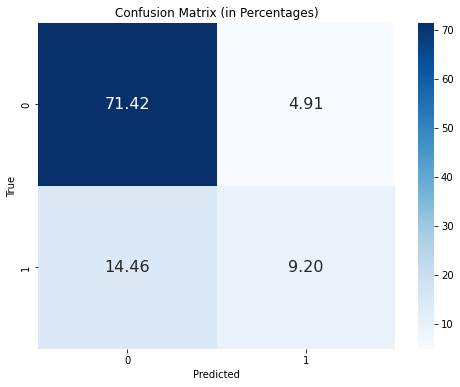

In [36]:
train_test_lr(bow, y_train, bow2, df_y)
#train_test_KNeighborsClassifier(bow, y_train, bow2, df_y) #długo mieli


##########   RandomForestClassifier   ##########

F1 score:  0.4950564971751412 
Accuracy:  0.7727272727272727 
AUC:  0.6685596518965438 
Gini:  0.3371193037930875
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4803
           1       0.52      0.47      0.50      1489

    accuracy                           0.77      6292
   macro avg       0.68      0.67      0.67      6292
weighted avg       0.77      0.77      0.77      6292



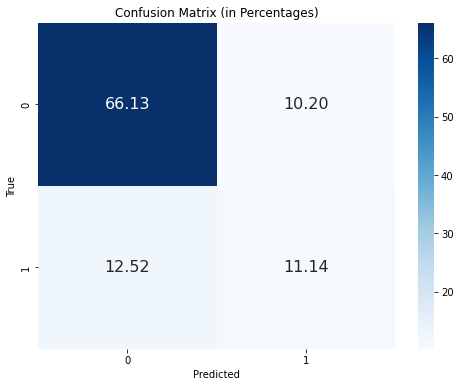

In [37]:
train_test_RandomForestClassifier(bow, y_train, bow2, df_y)


##########   DecisionTreeClasifier   ##########

F1 score:  0.45705024311183146 
Accuracy:  0.7337889383343928 
AUC:  0.6439815360530629 
Gini:  0.2879630721061257
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4803
           1       0.44      0.47      0.46      1489

    accuracy                           0.73      6292
   macro avg       0.64      0.64      0.64      6292
weighted avg       0.74      0.73      0.74      6292



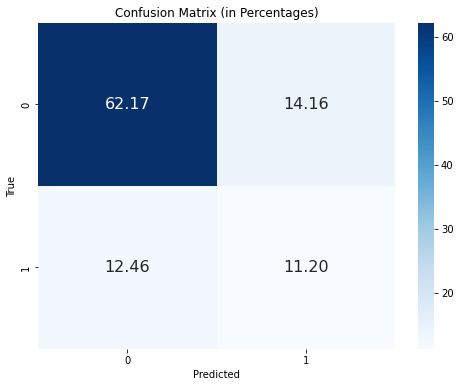

In [38]:
train_test_DecisionTreeClasifier(bow, y_train, bow2, df_y)


##########   MLPClassifier   ##########

F1 score:  0.0 
Accuracy:  0.7633502860775588 
AUC:  0.5 
Gini:  0.0
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      4803
           1       0.00      0.00      0.00      1489

    accuracy                           0.76      6292
   macro avg       0.38      0.50      0.43      6292
weighted avg       0.58      0.76      0.66      6292



c:\Users\macie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


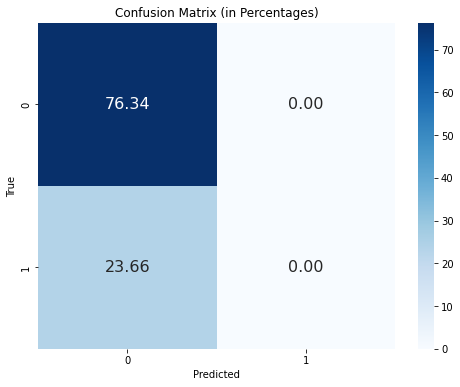

In [39]:
train_test_MLPClassifier(bow, y_train, bow2, df_y)

### Tensorflow model

In [ ]:
# read the CSV file
x_train = pd.read_csv('../data/x_train.csv')
x_valid = pd.read_csv('../data/x_valid.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_valid = pd.read_csv('../data/y_valid.csv')
x_test = pd.read_csv("..//data//x_test.csv")
y_test = pd.read_csv("..//data//y_test.csv")

In [ ]:
# for building team
df_x = x_valid
df_y = y_valid

In [ ]:
# for validation team
# df_x = x_test
# df_y = y_test

In [ ]:
# replacing 4 with 1 in the target column to make it binary
y_train['Target'] = y_train['Target'].replace(4, 1)
df_y['Target'] = df_y['Target'].replace(4, 1)

In [ ]:
# making training and testing sentences
training_sentences = x_train['Text'].tolist()
testing_sentences = df_x['Text'].tolist()

In [ ]:
# making training and testing labels
training_labels = y_train['Target'].tolist()
testing_labels = df_y['Target'].tolist()

In [ ]:
# some necessary variables
vocab_size = 10000
oov_tok = "<OOV>"
max_length = 80
embedding_dim = 16

In [ ]:
# changing the sentences into sequences
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_length, 
                                padding = 'post',
                                truncating = 'post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, 
                                maxlen = max_length,
                                padding = 'post',
                                truncating = 'post')

In [ ]:
# changing the lists into arrays for the model
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
# creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# number of epochs to train the model
num_epochs = 2

In [ ]:
# training and testing the model
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, 
                                     testing_labels), 
                    verbose=2)

In [ ]:
# plotting the accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
pred = model.predict(testing_padded)

In [ ]:
auc = roc_auc_score(testing_labels, pred)
gini = 2 * auc - 1
gini